In [29]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
import io
import itertools
from packaging import version
from six.moves import range
import sklearn.metrics

In [2]:
fashion_mnist = tf.keras.datasets.fashion_mnist

In [3]:
(train_img, train_lb), (test_img, test_lb)=fashion_mnist.load_data()

In [4]:
train_img.shape

(60000, 28, 28)

In [5]:
len(train_img)

60000

In [6]:
noms_classes=['T-shirt', 'Pantalon', 'Pullover', 'Robe', 'Veste',
               'Sandale', 'Chemise', 'Sneaker', 'Sac', 'Botte']

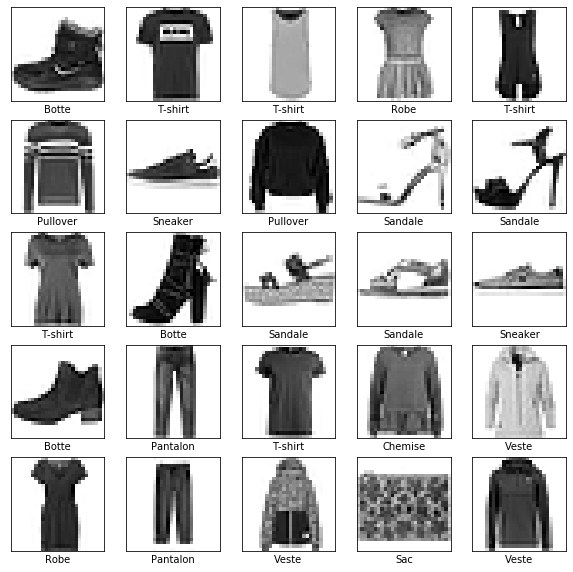

In [7]:
plt.figure(figsize=(10,10))
for i in range(25):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(train_img[i], cmap=plt.cm.binary)
    plt.xlabel(noms_classes[train_lb[i]])
plt.show()

In [8]:
train_img=train_img/255.0 #normalisation des images -> valeurs de 0 à 1
test_img=test_img/255.0

In [9]:
train_img = train_img[..., tf.newaxis]
test_img = test_img[..., tf.newaxis]

In [15]:
modele=tf.keras.Sequential() #construction du réseau
modele.add(tf.keras.layers.Conv2D(16, (4, 4), activation='relu'))
modele.add(tf.keras.layers.MaxPooling2D((2, 2)))
modele.add(tf.keras.layers.Conv2D(16, (4, 4), activation='relu'))
modele.add(tf.keras.layers.MaxPooling2D((2, 2)))
modele.add(tf.keras.layers.Flatten())
modele.add(tf.keras.layers.Dense(128, activation='relu'))
modele.add(tf.keras.layers.Dense(10, activation='softmax'))
opt = tf.keras.optimizers.SGD(lr=0.01)
loss=tf.keras.losses.SparseCategoricalCrossentropy()

In [16]:
modele.compile(opt, loss, metrics=['accuracy'])

In [17]:
modele.fit(train_img, train_lb, epochs=5)

Train on 60000 samples
Epoch 1/5
60000/60000 [==============================] - 13s 209us/sample - loss: 0.9699 - accuracy: 0.6480
Epoch 2/5
60000/60000 [==============================] - 13s 219us/sample - loss: 0.5889 - accuracy: 0.7796
Epoch 3/5
60000/60000 [==============================] - 12s 198us/sample - loss: 0.5136 - accuracy: 0.8109
Epoch 4/5
60000/60000 [==============================] - 12s 197us/sample - loss: 0.4704 - accuracy: 0.8287
Epoch 5/5
60000/60000 [==============================] - 12s 194us/sample - loss: 0.4388 - accuracy: 0.8397


In [18]:
print(modele.summary())

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_2 (Conv2D)            multiple                  272       
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 multiple                  0         
_________________________________________________________________
conv2d_3 (Conv2D)            multiple                  4112      
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 multiple                  0         
_________________________________________________________________
flatten_1 (Flatten)          multiple                  0         
_________________________________________________________________
dense_2 (Dense)              multiple                  32896     
_________________________________________________________________
dense_3 (Dense)              multiple                 

In [19]:
modele.evaluate(test_img, test_lb)

10000/1 [===============================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

[0.4457599973201752, 0.8378]

In [41]:
def plot_confusion_matrix(cm, noms_classes):
  """
  Returns a matplotlib figure containing the plotted confusion matrix.

  Args:
    cm (array, shape = [n, n]): a confusion matrix of integer classes
    class_names (array, shape = [n]): String names of the integer classes
  """
  figure = plt.figure(figsize=(8, 8))
  plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
  plt.title("Confusion matrix")
  plt.colorbar()
  tick_marks = np.arange(len(noms_classes))
  plt.xticks(tick_marks, noms_classes, rotation=45)
  plt.yticks(tick_marks, noms_classes)

  # Normalize the confusion matrix.
  cm = np.around(cm.astype('float') / cm.sum(axis=1)[:, np.newaxis], decimals=2)

  # Use white text if squares are dark; otherwise black.
  threshold = cm.max() / 2.
  for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    color = "white" if cm[i, j] > threshold else "black"
    plt.text(j, i, cm[i, j], horizontalalignment="center", color=color)

  plt.tight_layout()
  plt.ylabel('True label')
  plt.xlabel('Predicted label')
  return figure

In [42]:
# Clear out prior logging data.
!rm -rf logs/image

logdir = "logs/image/" + datetime.now().strftime("%Y%m%d-%H%M%S")
# Define the basic TensorBoard callback.
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir)
file_writer_cm = tf.summary.create_file_writer(logdir + '/cm')

'rm' n’est pas reconnu en tant que commande interne
ou externe, un programme exécutable ou un fichier de commandes.


In [43]:
def log_confusion_matrix(epoch, logs):
  # Use the model to predict the values from the validation dataset.
  test_pred_raw = model.predict(test_img)
  test_pred = np.argmax(test_pred_raw, axis=1)

  # Calculate the confusion matrix.
  cm = sklearn.metrics.confusion_matrix(test_lb, test_pred)
  # Log the confusion matrix as an image summary.
  figure = plot_confusion_matrix(cm, noms_classes=noms_classes)
  cm_image = plot_to_image(figure)

  # Log the confusion matrix as an image summary.
  with file_writer_cm.as_default():
    tf.summary.image("Confusion Matrix", cm_image, step=epoch)

# Define the per-epoch callback.
cm_callback = tf.keras.callbacks.LambdaCallback(on_epoch_end=log_confusion_matrix)

In [ ]:
# Start TensorBoard.
%load_ext tensorboard
!tensorboard --logdir logs/image

# Train the classifier.
modele.fit(
    train_img,
    train_lb,
    epochs=5,
    verbose=0, # Suppress chatty output
    callbacks=[tensorboard_callback, cm_callback],
    validation_data=(test_img, test_lb),
)

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard
